# Setup an ODE system

PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

Using PyGOM, we will set up my simple SCEIR model

## Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) (S + c_0 S_c) - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I_3. To implement this we would need to further distinguish careful and non careful infectives at least up to the I_1 level. This is done in the SCCEIR model.

## Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I_1+I_2+I_3+R+D$ Total population size (constant)

## Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible




## Implementation

In [1]:
# import required packages
import os 
from sympy import symbols, init_printing
import numpy as np
import matplotlib.pyplot as plt
import sympy
import itertools
import scipy
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize


In [2]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        Corrected by John McCaskill to avoid subscript format error
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + '{' + str(self._stateList[i]) + '}'+ '/dt=')
            B[i,1] = A[i]

        return B

In [3]:
# set up the symbolic SCEIR model

state = ['S', 'E', 'I_1', 'I_2','I_3','R','D','S_1']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_1', equation='c_2*I_3*S',
               transition_type=TransitionType.T),
    Transition(origin='S_1', destination='S', equation='c_1*S_1',
               transition_type=TransitionType.T),
    Transition(origin='S_1', destination='E', equation='c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S_1',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SCEIR_model = DeterministicOde(state, param_list, transition=transition)

In [4]:
# display equations
print_ode2(SCEIR_model)

Matrix([
[  d{S}/dt=,                                      -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_1*c_1],
[  d{E}/dt=, -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_1*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[d{I_1}/dt=,                                                                      E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                                                                      I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[d{I_3}/dt=,                                                                       I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                                              I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[  d{D}/dt=,                                                                                               I_3*mu],
[d{S_1}/dt=,                                 I_3*S*c_2 - S_1*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) - S_1*c_1]])

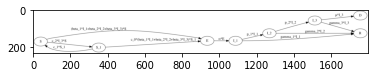

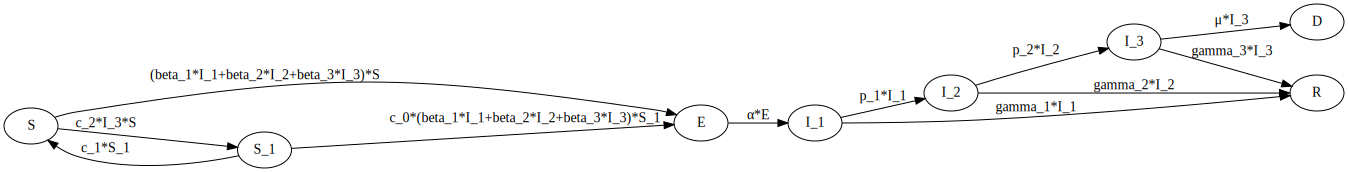

In [5]:
# display graphical representation of the model
SCEIR_model.get_transition_graph()

In [6]:
SCEIR_model.get_ode_eqn()

Matrix([
[                                     -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_1*c_1],
[-E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_1*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[                                                                     E*alpha - I_1*gamma_1 - I_1*p_1],
[                                                                     I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[                                                                      I_2*p_2 - I_3*gamma_3 - I_3*mu],
[                                                             I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[                                                                                              I_3*mu],
[                                I_3*S*c_2 - S_1*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) - S_1*c_1]])

In [7]:
SCEIR_model.get_jacobian_eqn()

Matrix([
[-I_1*beta_1 - I_2*beta_2 - I_3*beta_3 - I_3*c_2,      0,                 -S*beta_1,                 -S*beta_2,         -S*beta_3 - S*c_2, 0, 0,                                               c_1],
[           I_1*beta_1 + I_2*beta_2 + I_3*beta_3, -alpha, S*beta_1 + S_1*beta_1*c_0, S*beta_2 + S_1*beta_2*c_0, S*beta_3 + S_1*beta_3*c_0, 0, 0,        c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[                                              0,  alpha,            -gamma_1 - p_1,                         0,                         0, 0, 0,                                                 0],
[                                              0,      0,                       p_1,            -gamma_2 - p_2,                         0, 0, 0,                                                 0],
[                                              0,      0,                         0,                       p_2,             -gamma_3 - mu, 0, 0,                                                 0],
[     

In [8]:
SCEIR_model.get_grad_eqn()

Matrix([
[             -I_1*S,              -I_2*S,              -I_3*S,  0,    0,    0,    0,    0,    0,    0,                                           0,  S_1, -I_3*S, 0],
[I_1*S + I_1*S_1*c_0, I_2*S + I_2*S_1*c_0, I_3*S + I_3*S_1*c_0, -E,    0,    0,    0,    0,    0,    0,  S_1*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3),    0,      0, 0],
[                  0,                   0,                   0,  E, -I_1,    0,    0, -I_1,    0,    0,                                           0,    0,      0, 0],
[                  0,                   0,                   0,  0,    0, -I_2,    0,  I_1, -I_2,    0,                                           0,    0,      0, 0],
[                  0,                   0,                   0,  0,    0,    0, -I_3,    0,  I_2, -I_3,                                           0,    0,      0, 0],
[                  0,                   0,                   0,  0,  I_1,  I_2,  I_3,    0,    0,    0,                                           0,    0,  

In [9]:
transition

[Transition('S', '(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S', 'T', 'E', None, None),
 Transition('S', 'c_2*I_3*S', 'T', 'S_1', None, None),
 Transition('S_1', 'c_1*S_1', 'T', 'S', None, None),
 Transition('S_1', 'c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S_1', 'T', 'E', None, None),
 Transition('E', 'alpha*E', 'T', 'I_1', None, None),
 Transition('I_1', 'gamma_1*I_1', 'T', 'R', None, None),
 Transition('I_2', 'gamma_2*I_2', 'T', 'R', None, None),
 Transition('I_3', 'gamma_3*I_3', 'T', 'R', None, None),
 Transition('I_1', 'p_1*I_1', 'T', 'I_2', None, None),
 Transition('I_2', 'p_2*I_2', 'T', 'I_3', None, None),
 Transition('I_3', 'mu*I_3', 'T', 'D', None, None)]

## Simulation

{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}


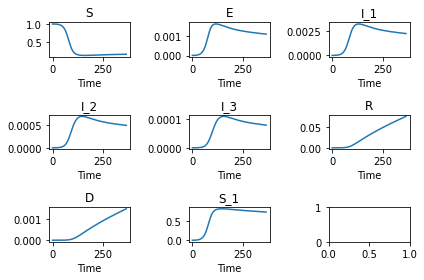

Peak infection (days) 131.0


In [172]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, 365, 366)

# initial conditions assuming there is no natural immunity
E_0 =  0.00001
x0 = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCEIR_model.initial_values = (x0, t[0])
SCEIR_model.parameters = params
solution = SCEIR_model.integrate(t[1::])
#mpl.figure(figsize=(2000,2000))
SCEIR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

(0.0, 1.0)

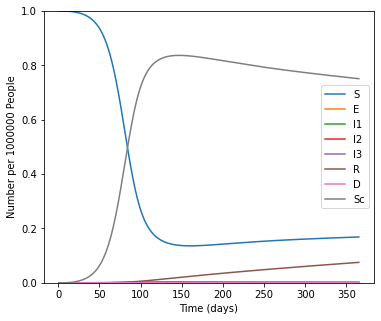

In [171]:
# solution = scipy.integrate.odeint(SCEIR_model.ode, x0, t)
# print(len(t))
solution1 = scipy.integrate.odeint(SCEIR_model.ode, x0, t[1::])
ys = solution1.copy()
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(t[1::],ys)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.ylim([0,1])

# Parameter fitting

## Generate test data based on simulation above

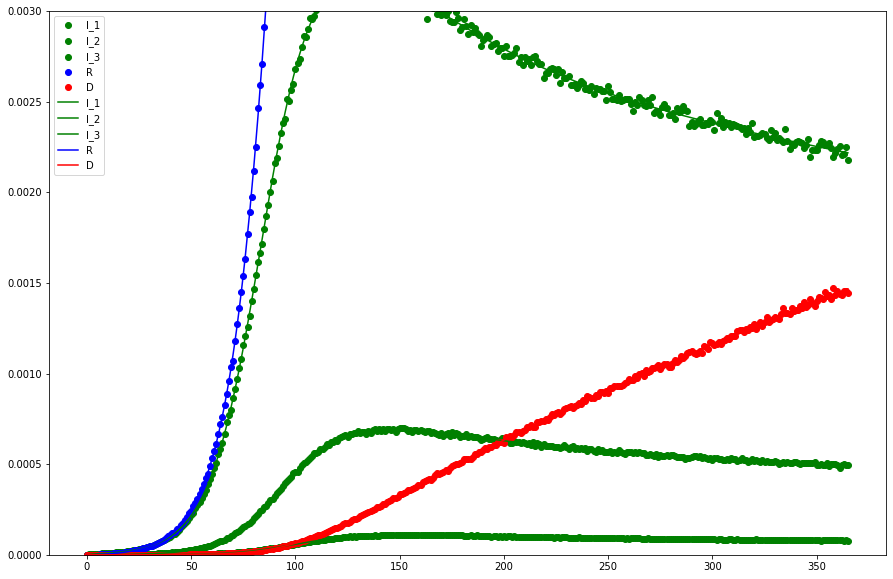

In [226]:
# Add noise
y = solution[:,2:7].copy()
#print('len(y)',len(y),'t',len(t),t[0],t[1],'...',t[-1])
np.random.seed(seed=6)
noise = np.random.normal(0,1.e-2,[len(t),5])
# ynoise = y *(1+noise)
ynoise = y *(1.0 + noise)
ynoise[ynoise<0] = 0
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go', label='I_1') 
plt.plot(t,ynoise[:,1], 'go', label='I_2') 
plt.plot(t,ynoise[:,2], 'go', label='I_3') 
plt.plot(t,ynoise[:,3], 'bo', label='R') 
plt.plot(t,ynoise[:,4], 'ro', label='D') 
plt.plot(t,y[:,0], 'g', label='I_1') 
plt.plot(t,y[:,1], 'g', label='I_2') 
plt.plot(t,y[:,2], 'g', label='I_3') 
plt.plot(t,y[:,3], 'b', label='R') 
plt.plot(t,y[:,4], 'r', label='D') 
plt.legend()
plt.ylim(0,0.003)
plt.show()

{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}
0.3 0.07142857142857142
[0.99999, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
366
Peak infection (days) 131.0


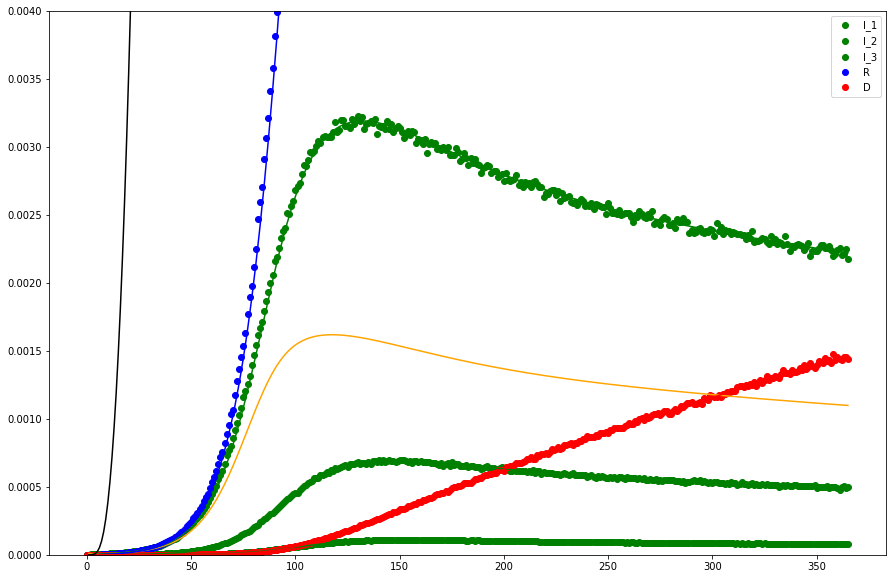

In [227]:
# model with fitted parameters 
print(params)
params_fit = params.copy()
print(params_fit['c_0'],params_fit['c_1'])
SCEIR_model.params = params_fit

x0_fit = x0.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SCEIR_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEIR_model.integrate(t_fit[1::]) # use magic %timeit to time
#sol_fit =SCEIR_model.integrate(t_fit[1::])
# sol_fit = SCEIR_model.integrate(t_fit)
sol_fit = scipy.integrate.odeint(SCEIR_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go',label='I_1') # infected observations
plt.plot(t,ynoise[:,1], 'go',label='I_2') # infected observations
plt.plot(t,ynoise[:,2], 'go',label='I_3') # infected observations
plt.plot(t,ynoise[:,3], 'bo',label='R') # recoverd
plt.plot(t,ynoise[:,4], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

In [228]:
params # use list(...) to convert to list

{'beta_1': 0.25,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.08000000000000002,
 'gamma_2': 0.06818181818181818,
 'gamma_3': 0.08571428571428572,
 'p_1': 0.01999999999999999,
 'p_2': 0.022727272727272728,
 'mu': 0.057142857142857134,
 'c_0': 0.3,
 'c_1': 0.07142857142857142,
 'c_2': 4000.0,
 'N': 1.0}

## Fit parameters to data based on square_loss

### Fit c_0 and c_1 only

In [229]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [value for value in cautionparams]
theta = [0.21,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEIR = SquareLoss(theta=theta, ode=SCEIR_model, x0=x0, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.0,1.0],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'])
# perform optimization
res = minimize(fun=objSCEIR.cost,
                jac=objSCEIR.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17
      fun: 5.2370523046636305e-05
 hess_inv: array([[ 6.5435233 , -3.80237909],
       [-3.80237909,  2.21730132]])
      jac: array([5.12840539e-07, 1.03645912e-06])
  message: 'Optimization terminated successfully.'
     nfev: 17
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([0.30001817, 0.07143385])


### Fit c_0 and c_1 as well as initial value of E

#### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [233]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEIR = SquareLoss(theta=theta, ode=SCEIR_model, x0=x0, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEIR.costIV,
                jac=objSCEIR.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='SLSQP',
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008069722905902119
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
     fun: 0.008069722905902119
     jac: array([ -0.46414337,  -0.91951214, -30.66908974])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.50000305e-01, 8.00006041e-02, 7.01504178e-05])


#### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [234]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEIR = SquareLoss(theta=theta, ode=SCEIR_model, x0=x0, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEIR.costIV,
                jac=objSCEIR.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28
      fun: 5.237030869159152e-05
 hess_inv: array([[ 2.37695012e+01, -1.48050709e+01,  1.76434567e-03],
       [-1.48050709e+01,  9.24077147e+00, -1.12037211e-03],
       [ 1.76434567e-03, -1.12037211e-03,  1.69987108e-07]])
      jac: array([-3.87350309e-06, -5.89406216e-06,  8.07388197e-04])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 21
     njev: 28
   status: 0
  success: True
        x: array([3.00105913e-01, 7.13780869e-02, 1.00085598e-05])


{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}
[0.99999, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}
Peak infection (days) 131.0


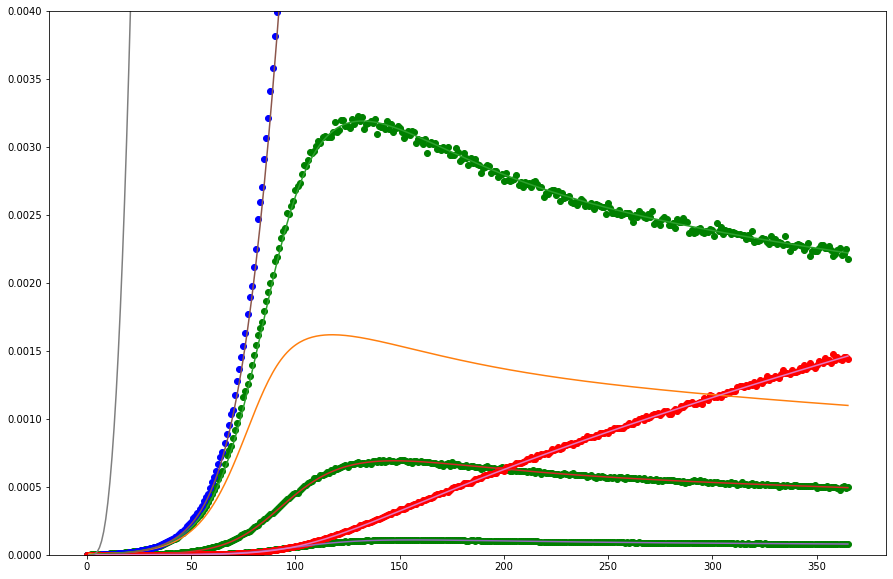

In [235]:
# model with fitted parameters 
print(params)
print(x0)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEIR_model.params = params_fit
print(SCEIR_model.params)
#ode_fit = common_models.SEIR({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEIR_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEIR_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEIR_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEIR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

#### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [243]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEIR = SquareLoss(theta=theta, ode=SCEIR_model, x0=x0, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEIR.costIV,
                jac=objSCEIR.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

      fun: 0.0014408506882318945
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -0.25523275,   -0.44944685, -143.39975413])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 3
   status: 0
  success: True
        x: array([2.63327726e-01, 8.62201392e-02, 1.27706706e-05])


In [244]:
objSCEIR.residual()

array([[-4.64874104e-07, -4.71254788e-09, -3.76375083e-11,
        -1.91441212e-08, -4.51127952e-13],
       [-7.69202132e-07, -1.70126212e-08, -2.63044631e-10,
        -7.15291868e-08, -7.60667289e-12],
       [-1.14007335e-06, -3.49884953e-08, -7.82400327e-10,
        -1.53281836e-07, -3.46680697e-11],
       ...,
       [ 1.09800659e-04,  3.66809253e-05,  4.22570122e-06,
         3.78933037e-03,  7.46958233e-05],
       [ 1.49786960e-04,  2.69897207e-05,  4.83617155e-06,
         4.80933805e-03,  7.36181741e-05],
       [ 7.89359554e-05,  3.02363362e-05,  3.55450194e-06,
         3.03086899e-03,  5.43499596e-05]])

#### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [240]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEIR = SquareLoss(theta=theta, ode=SCEIR_model, x0=x0, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEIR.costIV,
                #jac=objSCEIR.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 105
         Function evaluations: 183
 final_simplex: (array([[3.00127162e-01, 7.13630802e-02, 1.00133493e-05],
       [3.00152148e-01, 7.13518667e-02, 1.00101540e-05],
       [3.00030605e-01, 7.14242056e-02, 1.00003335e-05],
       [3.00209996e-01, 7.13099454e-02, 1.00171288e-05]]), array([5.23704515e-05, 5.23705086e-05, 5.23708349e-05, 5.23711041e-05]))
           fun: 5.23704514850903e-05
       message: 'Optimization terminated successfully.'
          nfev: 183
           nit: 105
        status: 0
       success: True
             x: array([3.00127162e-01, 7.13630802e-02, 1.00133493e-05])


{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}
[0.99999, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08000000000000002, 'gamma_2': 0.06818181818181818, 'gamma_3': 0.08571428571428572, 'p_1': 0.01999999999999999, 'p_2': 0.022727272727272728, 'mu': 0.057142857142857134, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 4000.0, 'N': 1.0}
Peak infection (days) 131.0


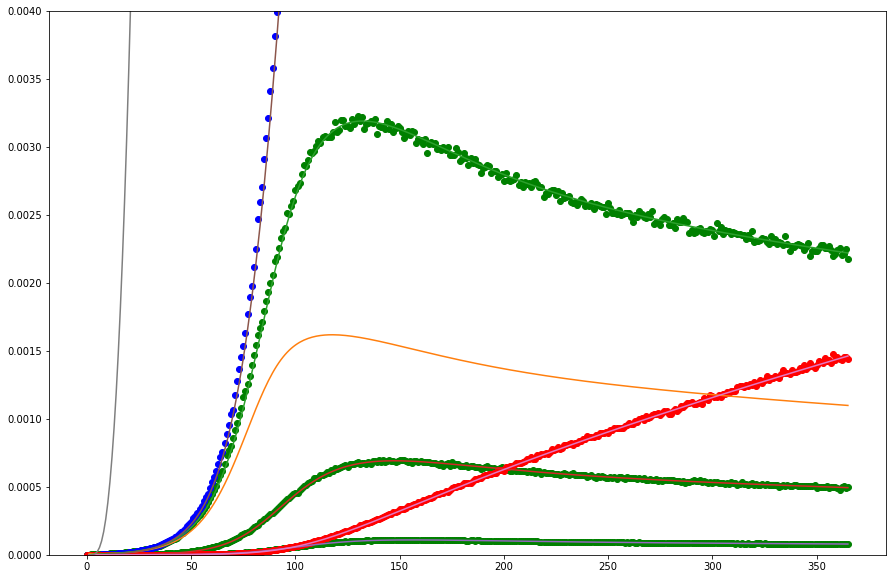

In [237]:
# model with fitted parameters 
print(params)
print(x0)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEIR_model.params = params_fit
print(SCEIR_model.params)
#ode_fit = common_models.SEIR({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEIR_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEIR_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEIR_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEIR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Information on method options

In [180]:
scipy.optimize.show_options(solver='minimize', method='SLSQP', disp=True)
print(' ')
scipy.optimize.show_options(solver='minimize', method='L-BFGS-B', disp=True)

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.
 
Minimize a scalar function of one or more variables using the L-BFGS-B
algorithm.

Options
-------
disp : None or int
    If `disp is None` (the default), then the supplied version of `iprint`
    is used. If `disp is not None`, then it overrides the supplied version
    of `iprint` with the behaviour you outlined.
maxcor : int
    The maximum number of variable metric corrections used to
    define the limited memory matrix. (The limited memory BFGS
    method does not store the full hessian but uses this many terms
    in an approximation to it.)
ftol : flo

## Plot using full control

In [239]:
def plotmodel(solns,t,scale='linear',species='no_susc',plottitle= '',label='',
              newplot = True,models=['SEIR','SCEIR','SCCEIR']):
    """
    plot solns over 
    times t interpreted as models indicated in models parameter
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
   
    nmodels = len(models)
    if len(solns) != len(models):
        print("Error: number of models must match number of solutions")
        return None
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
 
    for nm in range(nmodels):
        soln = solns[nm]
        if models[nm] == 'SEIR':   #SEIR
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(tvec,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(tvec,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                     plt.plot(t,suma,label=label)                   
            elif species == 'all':
                plt.plot(tvec,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SEIR %s' % plottitle)

        elif models[nm] == 'SCEIR':   #SCEIR
            #Plot
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCEIR %s' % plottitle)
        elif models[nm] == 'SCCEIR':   #SCCEIR
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,sol[:,1:5])
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1) + soln[:,9]
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    # plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    # plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCCEIR %s' % plottitle)
    return True

True

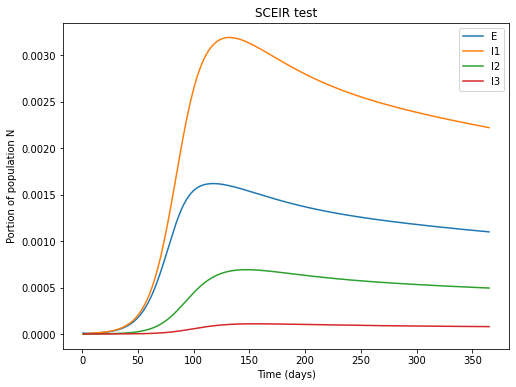

In [242]:
plotmodel([sol_fit],t_fit[1:],scale='linear',species='no_susc',plottitle= 'test',label='',
              newplot = True,models=['SCEIR'])

# Not yet implemented

In [ ]:
# R0 from arXiv paper
# does not work yet properly ! reason unclear
from pygom.model.epi_analysis import R0
ode1 = SCEIR_model.ode
ode2 = SimulateOde(state, param_list, transition=transition)
# print(ode2)
# ode = ode2.get_unrolled_obj() # Exception: Object was not initialized using a set of ode
# so need to define model via odes for this to work?
# R0( ode2, ['I_1','I_2','I_3'])

In [ ]:
# function for altering parameters
print(param_list) 
model = DeterministicOde(state, param_list, transition=transition)
def parameterize_model(t=np.linspace(0,365,366), c_0=0.3, c_1=0.07,
                       c_2=0.004,I1_init=0.00001, default_params = param_list, model=model):
    ic=[1-I1_init, I1_init, 0, 0, 0, 0, 0, 0]
    cautionparams = {'c_0': c_0,
              'c_1': c_1, 
              'c_2': c_2,
              'N': sum(ic)}
    
    model.initial_values = (ic, t[0])
    model.parameters = params
    sol = model.integrate(t[1::])
    model.plot()
    peak_i = np.argmax(sol[:,2])
    print('Peak infection (days)', t[peak_i] )
    

In this simple framework, reducing $\beta$ results in a smaller epidemic:
- the peak infection time is delayed
- the magnitude of peak infection is reduced.

Reducing beta may crudely represent giving out anti-virals, which make a person less infectious.

In [ ]:
parameterize_model(beta=1.2, t=np.linspace(0,500,5001))

Vaccinating 5% of the population (assuming instantaneous rollout) or natural immunity, delays the peak period, and reduces its magnitude.

In [ ]:
parameterize_model(ic=[9490,5, 5, 500], beta=0.5, gamma=0.3, t=np.linspace(0,150,10))

# gompy test example for FitzHugh model

In [ ]:
from unittest import main, TestCase

import numpy as np
from scipy.optimize import minimize

from pygom import SquareLoss
from pygom.model import common_models


class TestFHEstimate(TestCase):

    def setUp(self):
        # initial values
        x0 = [-1.0, 1.0]
        # params
        param_eval = [('a', 0.2), ('b', 0.2), ('c', 3.0)]
        self.target = np.array([0.2, 0.2, 3.0])
        # the time points for our observations
        t = np.linspace(0, 20, 30).astype('float64')
        ode = common_models.FitzHugh(param_eval)
        ode.initial_values = (x0, t[0])
        solution = ode.integrate(t[1::])
        self.theta = np.array([0.5, 0.5, 0.5])

        self.obj = SquareLoss(self.theta, ode, x0, t[0],
                              t[1::], solution[1::, :], ['V', 'R'])

        g = self.obj.gradient()
        assert np.linalg.norm(g) > 0

        EPSILON = np.sqrt(np.finfo(np.float).eps)

        self.box_bounds = [(EPSILON, 5.0)]*len(self.theta)

    def test_FH_sensitivity(self):
        res = minimize(fun=self.obj.cost,
                       jac=self.obj.sensitivity,
                       x0=self.theta,
                       bounds=self.box_bounds,
                       method='L-BFGS-B')

        self.assertTrue(np.allclose(self.target, res['x'], 1e-2, 1e-2))

    def test_FH_adjoint(self):
        res = minimize(fun=self.obj.cost,
                       jac=self.obj.adjoint,
                       x0=self.theta,
                       bounds=self.box_bounds,
                       method='L-BFGS-B')

        self.assertTrue(np.allclose(self.target, res['x'], 1e-2, 1e-2))

    def test_FH_IV(self):
        box_bounds = self.box_bounds + [(None, None)]*2

        res = minimize(fun=self.obj.costIV,
                       jac=self.obj.sensitivityIV,
                       x0=self.theta.tolist() + [-0.5, 0.5],
                       bounds=box_bounds,
                       method='L-BFGS-B')

        target = np.array([0.2, 0.2, 3.0, -1.0, 1.0])
        self.assertTrue(np.allclose(res['x'], target, 1e-2, 1e-2))

In [ ]:
test=TestFHEstimate()

In [ ]:
test.setUp()

In [ ]:
test.test_FH_IV()